In [1]:
import sys
import os

ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.abspath(ROOT))

In [2]:
from voxel_world.frame_loader import get_pointcloud, get_origin
from voxel_world.pc_processing import generate_freespace_pointcloud, generate_voxel_array_dense, voxel_matrix_to_coords, get_freespace_matrix

import numpy as np

In [3]:
#Define Frame Range
START_FRAME = 10        #first frame in the sequence
END_FRAME = 200         #last frame in the sequence
CURRENT_FRAME = 100

#Define Map-Type
REFERENCE_FRAME = "map" #options: "lidar", "map"
SENSOR = "radar"        #options: "lidar", "radar"

#Voxel-Parameters
X_RANGE = (-1250, -1200)
Y_RANGE = (1500, 1550)
Z_RANGE = (-5, 5)
CUBE_SIZE = 0.5         #Voxel-Map resolution
POINTS_PER_RAY = 20     #For freespace modelling
FREESPACE_TRESHOLD = 0
OCCUPIED_TRESHOLD = 0

#Define how many frames should be between frames determining dynamic cells
DELTA_FRAMES = 1    #needs to be positive


In [4]:
x_range = X_RANGE
y_range = Y_RANGE
z_range = Z_RANGE

cube_size = CUBE_SIZE
start_frame = START_FRAME
end_frame = END_FRAME

# compute number of voxels along each axis
nx = int(np.floor((x_range[1] - x_range[0]) / cube_size))
ny = int(np.floor((y_range[1] - y_range[0]) / cube_size))
nz = int(np.floor((z_range[1] - z_range[0]) / cube_size))

accumulated_occupied = np.zeros((nx, ny, nz), dtype=int)
accumulated_free = np.zeros((nx, ny, nz), dtype=int)

analyzed_frames = 0
for frame_number in range(start_frame, end_frame+1, DELTA_FRAMES):
    frame_str = f"{int(frame_number):05d}"

    # 2) Load point cloud for this frame
    pc = get_pointcloud(frame_str, reference_frame=REFERENCE_FRAME, sensor=SENSOR)
    sensor_origin = get_origin(SENSOR, REFERENCE_FRAME, frame_str)

    # 3) Generate occupied voxels
    occupied_voxel_matrix, translation = generate_voxel_array_dense(pc, cube_size, x_range, y_range, z_range)
    voxel_coords = voxel_matrix_to_coords(occupied_voxel_matrix, cube_size, translation, threshold=OCCUPIED_TRESHOLD)


    freespace_pc = generate_freespace_pointcloud(voxel_coords, sensor_origin, POINTS_PER_RAY)
    free_voxel_matrix, translation = generate_voxel_array_dense(freespace_pc, cube_size, x_range, y_range, z_range)
    free_voxels = get_freespace_matrix(free_voxel_matrix, occupied_voxel_matrix)

    # 6) accumulate
    normalized_occupied = (occupied_voxel_matrix > OCCUPIED_TRESHOLD).astype(int)
    normalized_free = (free_voxels > FREESPACE_TRESHOLD).astype(int)
    accumulated_occupied += normalized_occupied
    accumulated_free += normalized_free
    analyzed_frames += 1
    

1. Extract XYZ and translate PC: 0.000000s (0.000000s per point)
2. Voxel index conversion: 0.000000s (0.000000s per point)
3. Conversion to matrix: 0.005260s (0.000015s per point)

Total execution time: 0.005260s (0.000015s per point)
Occupied voxels: 163 / 200000
Elapsed time for computing freespace pointcloud: 0.000076 seconds
1. Extract XYZ and translate PC: 0.000000s (0.000000s per point)
2. Voxel index conversion: 0.000000s (0.000000s per point)
3. Conversion to matrix: 0.000000s (0.000000s per point)

Total execution time: 0.000000s (0.000000s per point)
Occupied voxels: 1604 / 200000
1. Extract XYZ and translate PC: 0.000000s (0.000000s per point)
2. Voxel index conversion: 0.000000s (0.000000s per point)
3. Conversion to matrix: 0.000000s (0.000000s per point)

Total execution time: 0.000000s (0.000000s per point)
Occupied voxels: 175 / 200000
Elapsed time for computing freespace pointcloud: 0.000071 seconds
1. Extract XYZ and translate PC: 0.000000s (0.000000s per point)
2. V

In [5]:
print("Analyzed Frames: ", analyzed_frames)

Analyzed Frames:  191


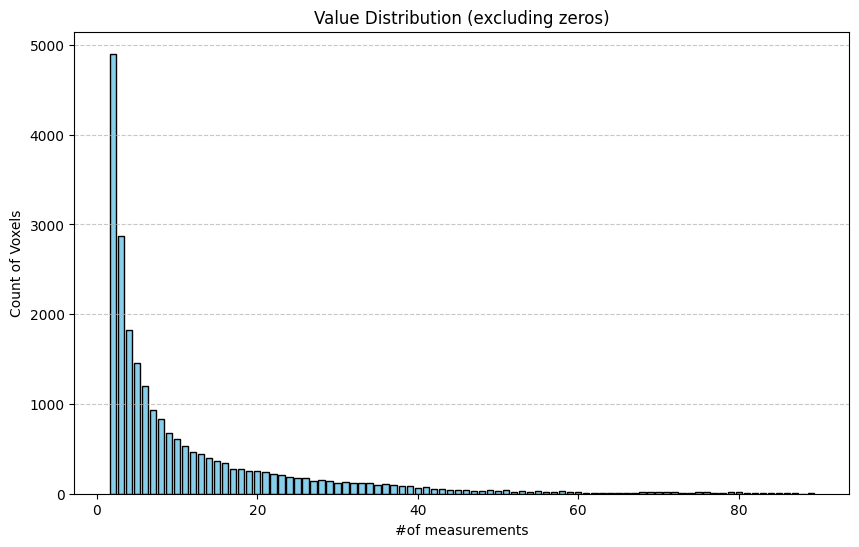

In [6]:
import matplotlib.pyplot as plt

MIN_FRAMES = 2
arr = accumulated_free + accumulated_occupied

# Assuming arr is your 100x100x20 array
values, counts = np.unique(arr, return_counts=True)

# Filter out zeros
nonzero_mask = values >= MIN_FRAMES
values = values[nonzero_mask]
counts = counts[nonzero_mask]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(values, counts, color='skyblue', edgecolor='black')
plt.xlabel('#of measurements')
plt.ylabel('Count of Voxels')
plt.title('Value Distribution (excluding zeros)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

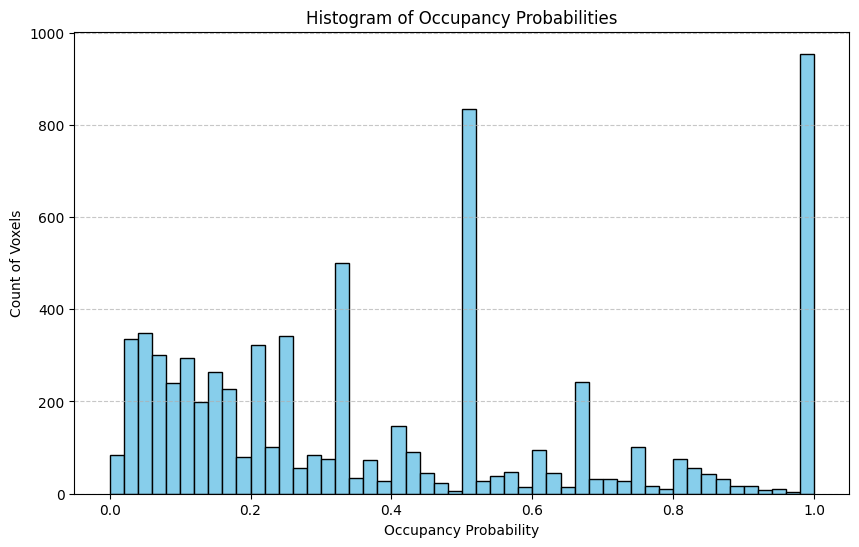

In [7]:
# Create probability array
denom = accumulated_occupied + accumulated_free

arr = np.divide(
    accumulated_occupied,
    denom,
    out=np.zeros_like(accumulated_occupied, dtype=float),
    where=denom >= MIN_FRAMES
)

# Flatten and filter out zeros (optional, if you don't want to include them)
filtered = arr[arr > 0]  # or use `arr[denom >= minimum_frames_for_valid_measurement]` if you want to include zeros

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered, bins=50, range=(0, 1), edgecolor='black', color='skyblue')
plt.xlabel('Occupancy Probability')
plt.ylabel('Count of Voxels')
plt.title('Histogram of Occupancy Probabilities')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


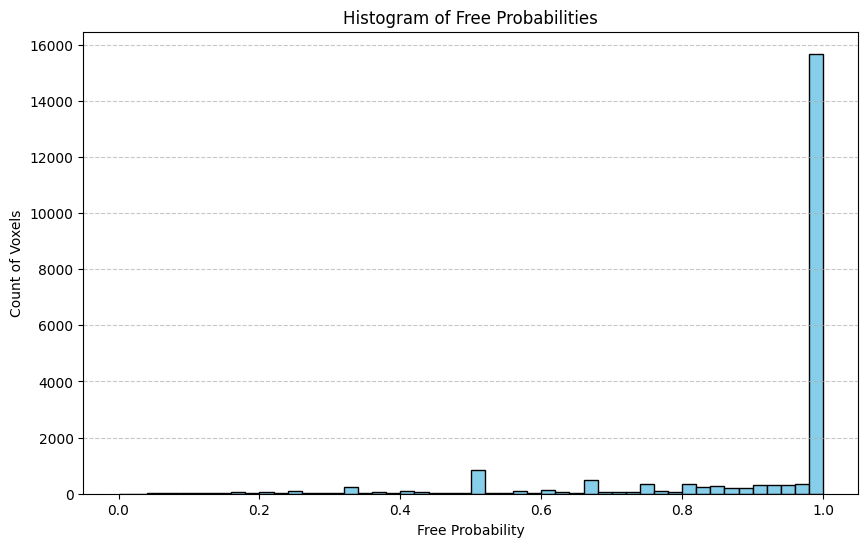

In [8]:
# Create probability array
denom = accumulated_occupied + accumulated_free

arr = np.divide(
    accumulated_free,
    denom,
    out=np.zeros_like(accumulated_occupied, dtype=float),
    where=denom >= MIN_FRAMES
)

# Flatten and filter out zeros (optional, if you don't want to include them)
filtered = arr[arr > 0]  # or use `arr[denom >= minimum_frames_for_valid_measurement]` if you want to include zeros

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered, bins=50, range=(0, 1), edgecolor='black', color='skyblue')
plt.xlabel('Free Probability')
plt.ylabel('Count of Voxels')
plt.title('Histogram of Free Probabilities')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

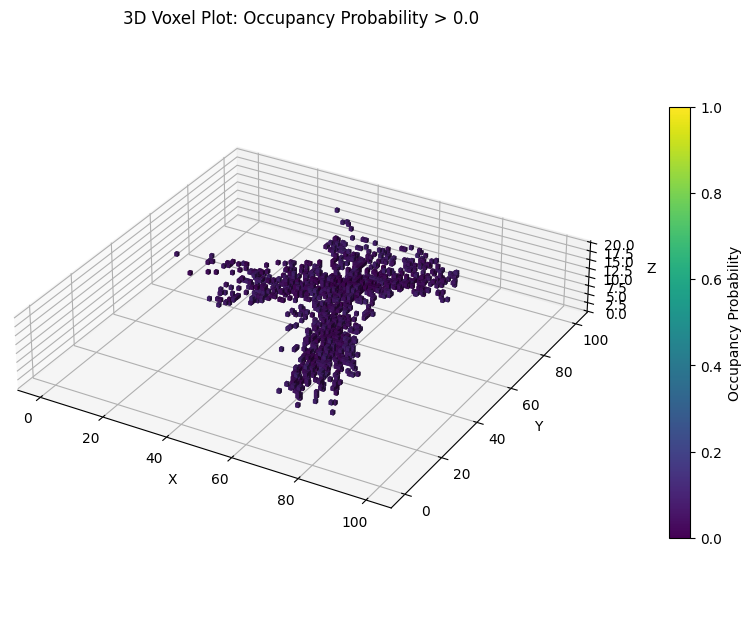

In [9]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Compute array (already provided)
arr = np.divide(
    accumulated_occupied,
    denom,
    out=np.zeros_like(accumulated_occupied, dtype=float),
    where=denom >= MIN_FRAMES
)

# Filter: only voxels with meaningful probability
mask = (arr > 0.0) & (arr <= 0.1)

# Normalize and apply colormap
norm = Normalize(vmin=0.0, vmax=1.0)
cmap = plt.cm.viridis
colors = cmap(norm(arr))

# Apply mask to facecolors
facecolors = np.zeros_like(colors)
facecolors[mask] = colors[mask]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(mask, facecolors=facecolors, edgecolors=None)  # Remove black edges

# Set equal aspect ratio (approximate workaround for 3D)
max_range = np.array(mask.shape).max()
ax.set_box_aspect([s / max_range for s in mask.shape])  # Aspect ratio hack

# Add colorbar using a fake ScalarMappable
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar to register

cbar = plt.colorbar(sm, shrink=0.7, pad=0.1)
cbar.set_label('Occupancy Probability')

# Axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Voxel Plot: Occupancy Probability > 0.0')
plt.show()


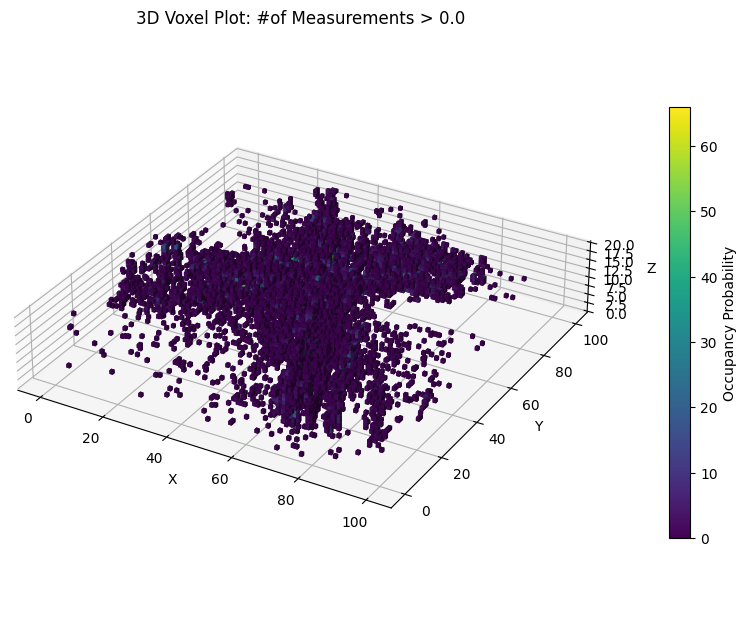

In [10]:
# Compute array (already provided)

occupied_prob = np.divide(
    accumulated_occupied,
    denom,
    out=np.zeros_like(accumulated_occupied, dtype=float),
    where=denom >= MIN_FRAMES
)

free_prob = np.divide(
    accumulated_free,
    denom,
    out=np.zeros_like(accumulated_occupied, dtype=float),
    where=denom >= MIN_FRAMES
)

arr = accumulated_occupied

# Filter: only voxels with meaningful probability
mask = (arr > 0.0)

# Normalize and apply colormap
norm = Normalize(vmin=0.0, vmax=arr.max())
cmap = plt.cm.viridis
colors = cmap(norm(arr))

# Apply mask to facecolors
facecolors = np.zeros_like(colors)
facecolors[mask] = colors[mask]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(mask, facecolors=facecolors, edgecolors=None)  # Remove black edges

# Set equal aspect ratio (approximate workaround for 3D)
max_range = np.array(mask.shape).max()
ax.set_box_aspect([s / max_range for s in mask.shape])  # Aspect ratio hack

# Add colorbar using a fake ScalarMappable
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for colorbar to register

cbar = plt.colorbar(sm, shrink=0.7, pad=0.1)
cbar.set_label('Occupancy Probability')

# Axis labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Voxel Plot: #of Measurements > 0.0')
plt.show()